# Task 2

---

## Predictive modeling of customer bookings



### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [64]:
print(df.isnull().sum())
print(df.shape)

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64
(50000, 14)


In [65]:
df.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [66]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [67]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [68]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [69]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [70]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete         

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [71]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

route                    0.054154
booking_origin           0.048114
flight_duration          0.014151
length_of_stay           0.007724
wants_extra_baggage      0.007103
wants_preferred_seat     0.003253
flight_hour              0.002873
num_passengers           0.002752
flight_day               0.002723
purchase_lead            0.001857
wants_in_flight_meals    0.001312
sales_channel            0.000000
trip_type                0.000000
Name: MI Scores, dtype: float64

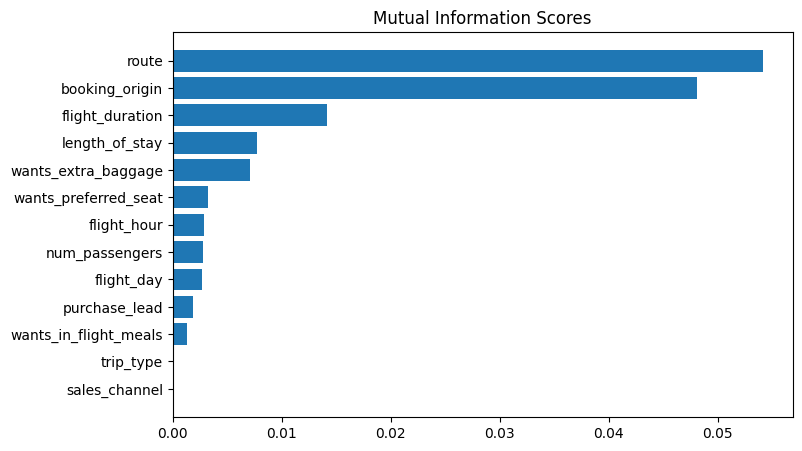

In [72]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

We can see

1. route
2. booking_origin
3. flight_duration
4. length_of_stay
5. wants_extra_baggage

are the top 5 features which are dependant with booking_complete feature

In [73]:
#test train split

from sklearn.model_selection import train_test_split

# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

In [74]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

## Random Forest Classifier with top 6 feature

In [75]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier



#assigning the features under a list

features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']
X= df[features]
#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  83.36
AUC score:  0.5657818407546988


## Random Forest Classifier with all features

In [76]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  84.84
AUC score:  0.5527766076821664


## XGB Classifier with top 6 feature

In [77]:
from xgboost import XGBClassifier

X =df[features]
X = pd.get_dummies(X, columns=features)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val = dataset(X,y)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
predict_xgb = xgb_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,predict_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,predict_xgb))

ACCURACY:  84.78999999999999
AUC score:  0.5231540310747802


## XGB Classifier with all features

In [78]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_predict = xgb.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,xgb_predict)*100)
print('AUC score: ',roc_auc_score(y_val,xgb_predict))

ACCURACY:  84.87
AUC score:  0.5358453436541607


### Random Forest Classifier is chosen as the best model as it has higher accuracy and AUC score than the other


Validating with test set

In [80]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

train_full_X,test_X, train_full_y, test_y = train_test_split(X, y,test_size=0.2,random_state = 0)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds= forest_model.predict(test_X)

print('ACCURACY: ',accuracy_score(test_y,preds)*100)
print('AUC score: ',roc_auc_score(test_y,preds))

ACCURACY:  85.37
AUC score:  0.5678474780954598
